In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *


from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, LabelEncoder #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix


## 0. Together

Random forests are a (typically) classification algorithm that makes decisions by iteratively splitting data into groups until a classification is made. The resulting splits make what is essentially a flow chart. These trees are made one split at a time, and each split is chosen by minimizing the chaos (entropy or impurity) at that particular split.

### 0.1 Building a Decision Tree

In [2]:
d = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")

In [3]:
predictors = ["Pregnancies","Glucose","BloodPressure","SkinThickness",
              "Insulin","BMI","DiabetesPedigreeFunction","Age"]
X = d[predictors]
y = d["Outcome"]

# TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1234)

d.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
tree = DecisionTreeClassifier(random_state = 1234)
tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1234)

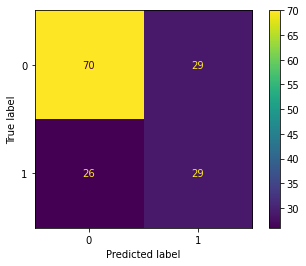

In [5]:
plot_confusion_matrix(tree, X_test, y_test)

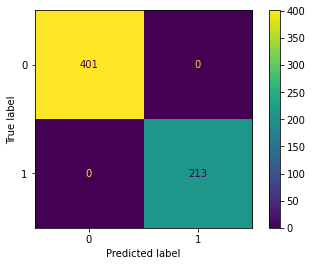

In [6]:
plot_confusion_matrix(tree, X_train, y_train)

### 0.2 What does this tell us?

And how can we fix things?
<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [7]:
# new model
tree.get_depth()

13

## 1. Pruning

It's your favorite time! Time to simulate some data.

### 1.1 Simulation

add the necessary code.

In [8]:
def simTree(n = 200, max_depth = "none"):
    
    n2 = int(n/2)
    
    #---generate data-----------------------------------
    # generate predictors, only x1 and x2 are related to the outcome
    x1 = np.concatenate([np.random.normal(0,1,n2),
                         np.random.normal(2,1,n2)])
    x2 = np.random.normal(0,1,n)
    x3 = np.concatenate([np.random.binomial(1,0.2,n2),
                        np.random.binomial(1,0.9, n2)])
    
    # generate outcome
    outcome = np.repeat(["A","B"], n2)
    
    # data frame
    df = pd.DataFrame({"x1": x1, "x2" : x2, "x3": x3, "out": outcome})
    
    #---set X and y------------------------------------
    X = df[["x1","x2","x3"]]
    y = df[["out"]]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

    
    #---build models------------------------------------
    
    # if there is no max depth, build regular tree
    if max_depth == "none":
        tree = DecisionTreeClassifier() 
        
    # otherwise, set max_depth
    else:
        tree = DecisionTreeClassifier(max_depth = max_depth)
        
    tree.fit(X_train,y_train)
    
    
    #---get training and test Accuracy---------------------
    train_acc = accuracy_score(y_train,tree.predict(X_train))
    test_acc = accuracy_score(y_test,tree.predict(X_test))
    
    return(pd.DataFrame({"Set": ["Train", "Test",],
                        "Depth": [str(max_depth), str(max_depth)],
                        "Acc": [train_acc,
                               test_acc]}))
    
    

In [9]:
sims = [simTree(n = 2000, max_depth = x) for x in np.repeat(range(2,10), 100)]
sims = sims + [simTree(n = 2000, max_depth = "none") for i in range(0,100)]
sims_df = pd.concat(sims)

sims_df.head(6)

,Set,Depth,Acc
0,Train,2,0.910625
1,Test,2,0.930000
0,Train,2,0.925000
1,Test,2,0.897500
0,Train,2,0.906250
1,Test,2,0.897500


### 1.2 Plotting it!
Now that we've run our simulation, use the `sims_df` data frame to make a plot that shows us the difference between the train and test accuracy for our full (not limited) and pruned (has a max_depth) trees. 

Use `geom_boxplot()` to plot Acc for each Tree `Depth`. Fill by Set.

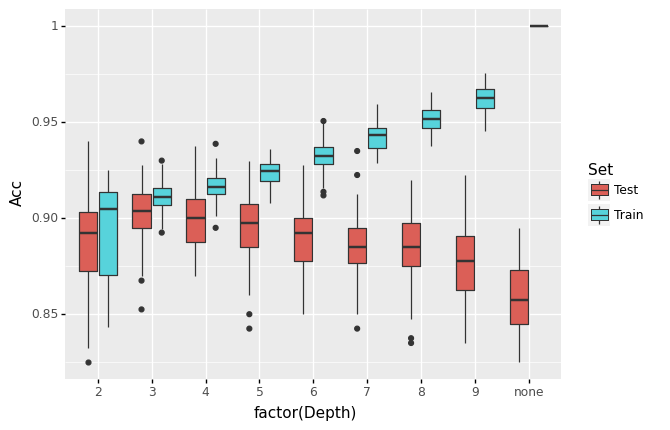

<ggplot: (99034353773)>

In [10]:
### YOUR CODE HERE ###

(ggplot(sims_df, aes(x="factor(Depth)", y="Acc", fill="Set")) + geom_boxplot())

### *Question*

#### What does this graph tell you about how setting max_depth affects overfitting?

The higher the max depth is set, the more overfit the data is. This causes higher max depths to have higher accuracies for the training set but lower accuracies for the test set.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


### *Question*

#### If you reduct the number of data points in the sample (by change the `n` argument to 200 in `simTree()`), what changes? Why do you think these changes occur?

With fewer data points, overfitting happens with much lower values for max depth than with more values. This is likely because when there are large numbers of data points, a subset of the group will be more representative of the whole when compared to a smaller data set using the same proportion of testing to training data.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


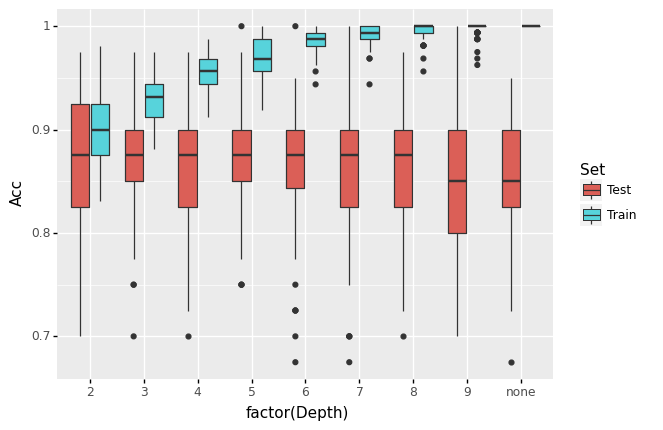

<ggplot: (99034415842)>

In [11]:
sims = [simTree(n = 200, max_depth = x) for x in np.repeat(range(2,10), 100)] ### Change n
sims = sims + [simTree(n = 200, max_depth = "none") for i in range(0,100)]    ### Change n
sims_df = pd.concat(sims)

# make same plot as above

(ggplot(sims_df, aes(x="factor(Depth)", y="Acc", fill="Set")) + geom_boxplot())